In [93]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction import extract_features
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
%pylab inline

np.random.seed(
    abs(hash('mit') // (2 ** 32 -1))
)

from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

from keras.layers import (
    SimpleRNN, Dense, LSTM,
    Embedding, Input, Dropout,
    Concatenate,Bidirectional,
    GlobalAveragePooling1D
)
from keras.models import Model
import keras.backend as K

Populating the interactive namespace from numpy and matplotlib


# Data Acquisition

In [94]:
data_folder = "/Users/youssefberrada/Documents/GitHub/PLAsTiCC-Astronomical-Classification/data/class_data/"

train = pd.read_csv(data_folder+'class_training_set.csv')
meta_train_full = pd.read_csv(data_folder+'class_training_set_meta.csv')

meta_test = pd.read_csv(data_folder+'class_test_set_meta.csv')
meta_test_full = pd.read_csv(data_folder+'class_test_set_meta.csv')

In [166]:
# Data Folder
data_folder = "/Users/youssefberrada/Documents/GitHub/PLAsTiCC-Astronomical-Classification/data/class_data/"


##### TRAIN
# Light GBM
pred_train= pd.read_csv(data_folder+'predictions_train.csv')
#Optimal Tree with Hyperplans
opt_train = np.loadtxt(data_folder+'Opt_Tree_predict_train.txt')
opt_train = pd.DataFrame(opt_train).assign(object_id =pd.Series(pred_train.object_id).values)
opt_train.columns = pred.columns

opt2_train = np.loadtxt(data_folder+'predict_train_balanced_entropy_train.txt')
opt2_train = pd.DataFrame(opt2_train).assign(object_id =pd.Series(pred_train.object_id).values)
opt2_train.columns = pred.columns
# Rnn
rnn_train = pd.read_csv(data_folder+'pred_train_RNN.csv')
rnn_train = pd.DataFrame(rnn_train).assign(object_id =pd.Series(pred_train.object_id).values)
rnn_train.columns = pred.columns




##### TEST
# Light GBM
pred= pd.read_csv(data_folder+'predictions_test.csv')
#Optimal Tree with Hyperplans
opt = np.loadtxt(data_folder+'Opt_Tree_predict_test.txt')
opt = pd.DataFrame(opt).assign(object_id =pd.Series(pred.object_id).values)
opt.columns = pred.columns

opt2 = np.loadtxt(data_folder+'predict_train_balanced_entropy_test.txt')
opt2 = pd.DataFrame(opt2).assign(object_id =pd.Series(pred.object_id).values)
opt2.columns = pred.columns

# Rnn
rnn = pd.read_csv(data_folder+'pred_test_RNN.csv')
rnn = pd.DataFrame(rnn).assign(object_id =pd.Series(pred.object_id).values)
rnn.columns = pred.columns

In [96]:
y_train = np.array(meta_train_full.target)
unique_y_train =np.unique(y_train)
class_map_train = dict()
for i,val in enumerate(unique_y_train):
    class_map_train[val] = i
        
y_map_train = np.zeros((y_train.shape[0],))
y_map_train = np.array([class_map_train[val] for val in y_train])



y_test = np.array(meta_test_full.target)
unique_y_test =np.unique(y_test)
class_map_test = dict()
for i,val in enumerate(unique_y_test):
    class_map_test[val] = i
        
y_map_test = np.zeros((y_test.shape[0],))
y_map_test = np.array([class_map_test[val] for val in y_test])


In [97]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix


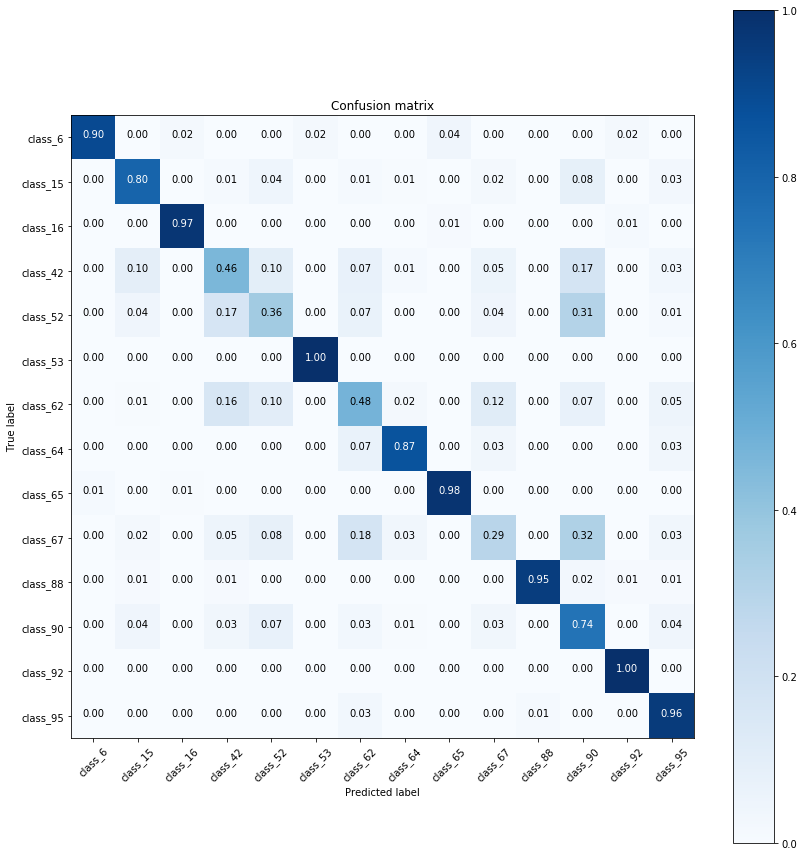

In [98]:
youssef = (0.7*pred+0.3*opt)/2
cnf_matrix = confusion_matrix(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [99]:
print('Light GBM Accuracy:' + str(accuracy_score(y_map_test, np.argmax(np.array(pred.drop('object_id',axis=1)),axis=1))))
print('Optimal Tree + H Accuracy:' +str(accuracy_score(y_map_test, np.argmax(np.array(opt.drop('object_id',axis=1)),axis=1))))
print('Ensemble Manual Accuracy:' +str(accuracy_score(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1))))


Light GBM Accuracy:0.7633204633204633
Optimal Tree + H Accuracy:0.16061776061776062
Ensemble Manual Accuracy:0.7517374517374518


In [183]:
K.clear_session()


model_input_1 = Input(shape=(14,)
)
hidden_state_1 = Dense(64, activation='relu')(model_input_1)
hidden_state_1 = Dropout(0.15)(hidden_state_1)
hidden_state_1 = Dense(64, activation='relu')(hidden_state_1)
hidden_state_1 = Dropout(0.15)(hidden_state_1)


model_input_2 = Input(shape=(14,)
)
hidden_state_2 = Dense(32, activation='relu')(model_input_2)
hidden_state_2 = Dropout(0.15)(hidden_state_2)
hidden_state_2 = Dense(32, activation='relu')(hidden_state_2)
hidden_state_2 = Dropout(0.15)(hidden_state_2)

model_input_3 = Input(shape=(14,)
)
hidden_state_3 = Dense(64, activation='relu')(model_input_3)
hidden_state_3 = Dropout(0.15)(hidden_state_3)
hidden_state_3 = Dense(64, activation='relu')(hidden_state_3)
hidden_state_3 = Dropout(0.15)(hidden_state_3)





hidden_state = Concatenate()([
    hidden_state_1,
    hidden_state_2, 
    hidden_state_3
])

hidden_state = Dense(128, activation='relu')(hidden_state)
hidden_state = Dropout(0.2)(hidden_state)
hidden_state = Dense(128, activation='relu')(hidden_state)
hidden_state = Dropout(0.2)(hidden_state)

output = Dense(14, activation='softmax')(hidden_state)
model = Model([model_input_1 ,model_input_2,model_input_3], output)
model.compile(
    optimizer='rmsprop', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [184]:
num_samples_to_train = 50
model.fit(
    [pred_train.drop('object_id',axis=1),opt_train.drop('object_id',axis=1),rnn_train.drop('object_id',axis=1)], 
    pd.get_dummies(y_train), 
    epochs=1000, shuffle=True, batch_size=num_samples_to_train, verbose=0
)


In [120]:
plot_model(model, to_file=data_folder+'model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

In [180]:
ens = model.predict([pred.drop('object_id',axis=1),opt.drop('object_id',axis=1),rnn.drop('object_id',axis=1)])
ens = pd.DataFrame(ens).assign(object_id =pd.Series(pred.object_id).values)
ens.columns = pred.columns

In [ ]:
cnf_matrix = confusion_matrix(y_map_test, np.argmax(np.array(pred.drop('object_id',axis=1)),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

Normalized confusion matrix


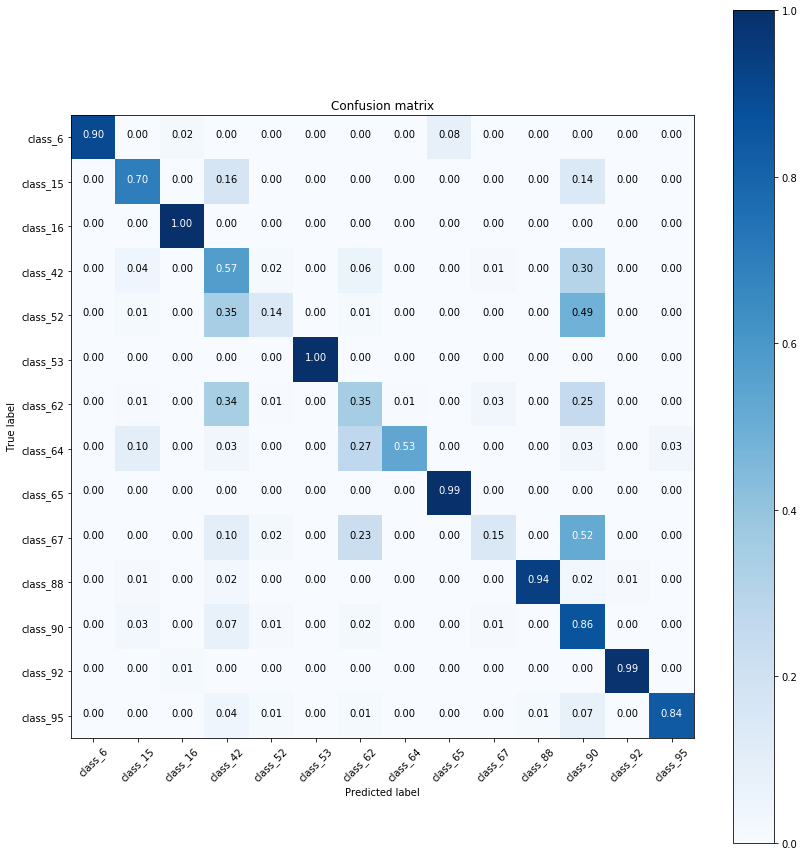

In [181]:
youssef = ens
cnf_matrix = confusion_matrix(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

Normalized confusion matrix


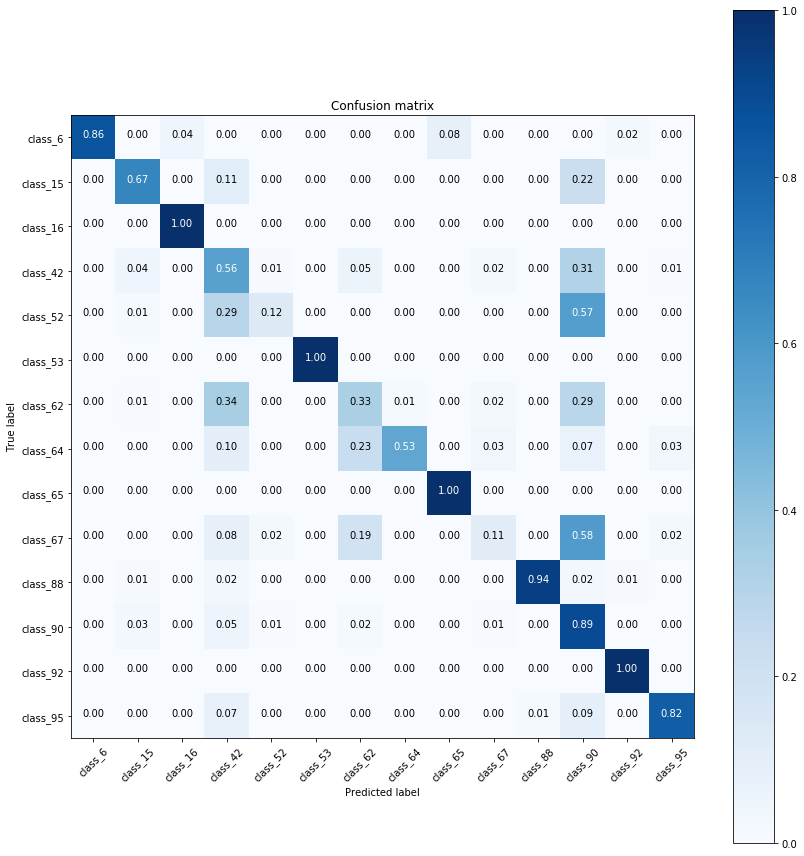

In [176]:
youssef = ens
cnf_matrix = confusion_matrix(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [182]:
print('Ensemble Accuracy:' +str(accuracy_score(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1))))
print('Ensemble Precision:' +str(precision_score(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1),average='macro')))
print('Ensemble Recall:' +str(recall_score(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1),average='macro')))
print('Ensemble F-1 Score:' +str(f1_score(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1),average='macro')))

Ensemble Accuracy:0.7783783783783784
Ensemble Precision:0.7857712768560028
Ensemble Recall:0.7109727681124408
Ensemble F-1 Score:0.7369044336123444


In [177]:
print('Ensemble Accuracy:' +str(accuracy_score(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1))))
print('Ensemble Precision:' +str(precision_score(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1),average='macro')))
print('Ensemble Recall:' +str(recall_score(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1),average='macro')))
print('Ensemble F-1 Score:' +str(f1_score(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1),average='macro')))

Ensemble Accuracy:0.7814671814671814
Ensemble Precision:0.7828045543048167
Ensemble Recall:0.7029143429832265
Ensemble F-1 Score:0.7281937736253473


In [169]:
print('LGBM Accuracy:' +str(accuracy_score(y_map_test, np.argmax(np.array(pred.drop('object_id',axis=1)),axis=1))))
print('LGBM Precision:' +str(precision_score(y_map_test, np.argmax(np.array(pred.drop('object_id',axis=1)),axis=1),average='macro')))
print('LGBM Recall:' +str(recall_score(y_map_test, np.argmax(np.array(pred.drop('object_id',axis=1)),axis=1),average='macro')))
print('LGBM F-1 Score:' +str(f1_score(y_map_test, np.argmax(np.array(pred.drop('object_id',axis=1)),axis=1),average='macro')))

LGBM Accuracy:0.7633204633204633
LGBM Precision:0.7188521957535199
LGBM Recall:0.768990779227902
LGBM F-1 Score:0.7365135916822186


In [170]:
print('OPT_H Accuracy:' +str(accuracy_score(y_map_test, np.argmax(np.array(opt.drop('object_id',axis=1)),axis=1))))
print('OPT_H Precision:' +str(precision_score(y_map_test, np.argmax(np.array(opt.drop('object_id',axis=1)),axis=1),average='macro')))
print('OPT_H Recall:' +str(recall_score(y_map_test, np.argmax(np.array(opt.drop('object_id',axis=1)),axis=1),average='macro')))
print('OPT_H F-1 Score:' +str(f1_score(y_map_test, np.argmax(np.array(opt.drop('object_id',axis=1)),axis=1),average='macro')))

OPT_H Accuracy:0.6710424710424711
OPT_H Precision:0.39009191105966184
OPT_H Recall:0.4598091245033569
OPT_H F-1 Score:0.41861789880114364


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [171]:
print('RNN Accuracy:' +str(accuracy_score(y_map_test, np.argmax(np.array(rnn.drop('object_id',axis=1)),axis=1))))
print('RNN Precision:' +str(precision_score(y_map_test, np.argmax(np.array(rnn.drop('object_id',axis=1)),axis=1),average='macro')))
print('RNN Recall:' +str(recall_score(y_map_test, np.argmax(np.array(rnn.drop('object_id',axis=1)),axis=1),average='macro')))
print('RNN F-1 Score:' +str(f1_score(y_map_test, np.argmax(np.array(rnn.drop('object_id',axis=1)),axis=1),average='macro')))

RNN Accuracy:0.6702702702702703
RNN Precision:0.6430374909112061
RNN Recall:0.6906773334594988
RNN F-1 Score:0.6560615437108896


Normalized confusion matrix


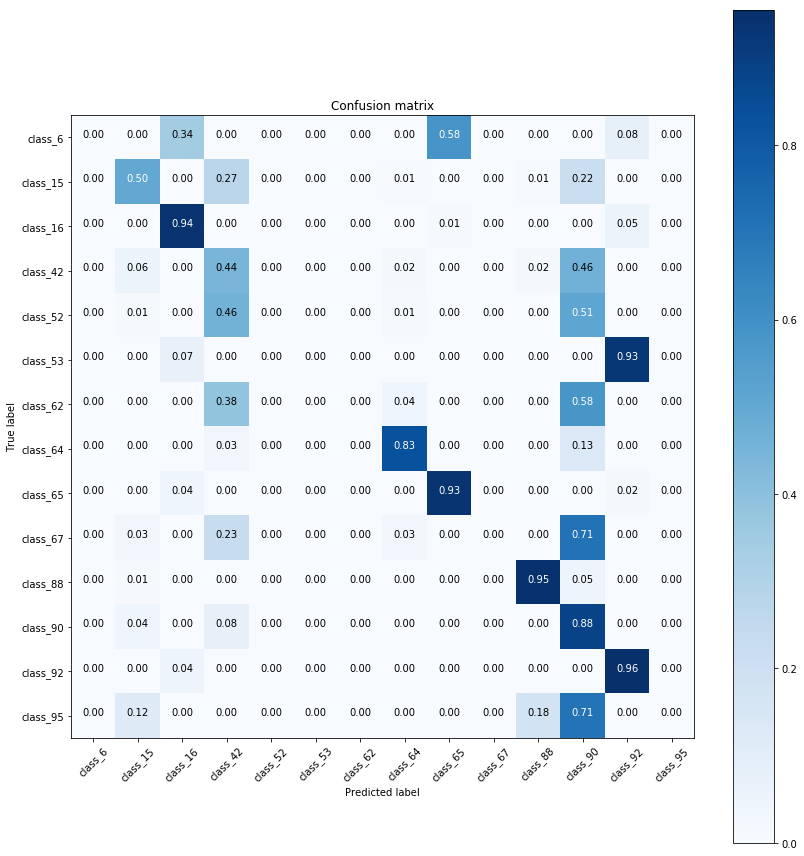

In [172]:
youssef = opt
cnf_matrix = confusion_matrix(y_map_test, np.argmax(np.array(youssef.drop('object_id',axis=1)),axis=1))
np.set_printoptions(precision=2)

sample_sub = pd.read_csv(data_folder+'sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;

# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')